<a href="https://colab.research.google.com/github/shadenAlsaif/FitChef_recipe_generator/blob/main/AI_for_CS_Assign_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ========== 1) LOAD THE DATASET ==========
import pandas as pd
import numpy as np

# Path to your downloaded CSV from Kaggle - https://www.kaggle.com/datasets/shashwatwork/web-page-phishing-detection-dataset?resource=download
path = "/content/dataset_phishing.csv"

df = pd.read_csv(path)

print("Shape:", df.shape)
display(df.head())

Shape: (11430, 89)


,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,http://www.crestonwood.com/router.php,37,19,0,3,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,77,23,1,1,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,phishing
2,https://support-appleld.com.secureupdate.duila...,126,50,1,4,1,0,1,2,0,...,1,0,0,14,4004,5828815,0,1,0,phishing


In [ ]:
print("\nInfo:")
print(df.info())


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11430 entries, 0 to 11429
Data columns (total 89 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   url                         11430 non-null  object 
 1   length_url                  11430 non-null  int64  
 2   length_hostname             11430 non-null  int64  
 3   ip                          11430 non-null  int64  
 4   nb_dots                     11430 non-null  int64  
 5   nb_hyphens                  11430 non-null  int64  
 6   nb_at                       11430 non-null  int64  
 7   nb_qm                       11430 non-null  int64  
 8   nb_and                      11430 non-null  int64  
 9   nb_or                       11430 non-null  int64  
 10  nb_eq                       11430 non-null  int64  
 11  nb_underscore               11430 non-null  int64  
 12  nb_tilde                    11430 non-null  int64  
 13  nb_percent              

In [ ]:
print("\nMissing values:")
print(df.isna().sum().sum())


Missing values:
0


In [ ]:
print("\nClass Labels:")

label_col_candidates = [c for c in df.columns if c.lower() in ["status","label","target","phishing","class"]]
print(df[label_col_candidates[0]].value_counts(dropna=False))


Class Labels:
status
legitimate    5715
phishing      5715
Name: count, dtype: int64


In [ ]:
# ========== 2) PREPROCESSING ==========
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Identify label column
y_col = [c for c in df.columns if c.lower() in ["status","label","target","phishing","class"]][0]

# Map labels to binary {benign:0, phishing:1} -- adjust if your CSV uses other strings
y_raw = df[y_col].astype(str).str.lower()
y = y_raw.map({"legitimate":0, "phishing":1}).astype(int)

# Drop non-feature columns (label + any obvious non-numeric IDs/URLs if present)
non_feature_cols = [y_col]
feature_df = df.drop(columns=non_feature_cols, errors="ignore")

# Keep only numeric columns for the classic ML pipeline
X = feature_df.select_dtypes(include=[np.number]).copy()

# Scale features
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9144, 87), (2286, 87), (9144,), (2286,))

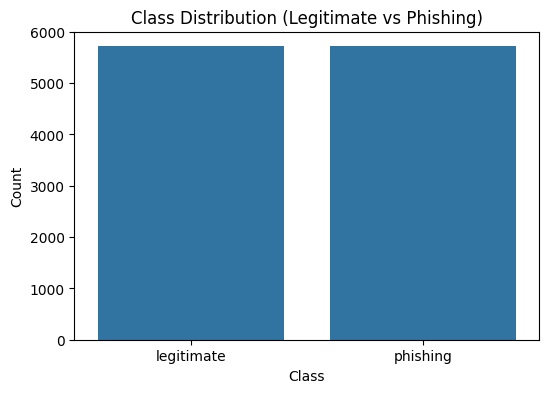

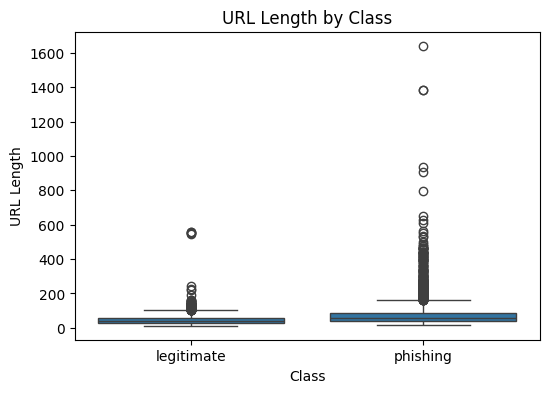

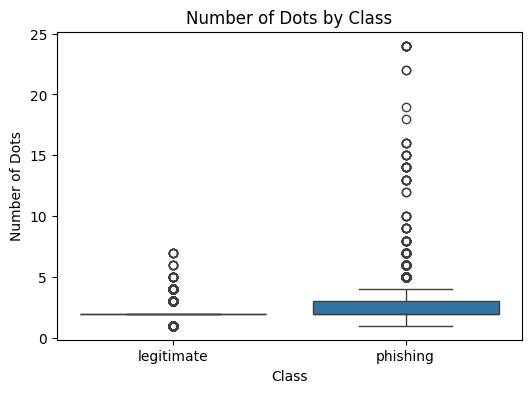

/tmp/ipython-input-3680912001.py:35: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['status']=='legitimate']['ratio_digits_url'], label='Legitimate', shade=True)
/tmp/ipython-input-3680912001.py:36: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['status']=='phishing']['ratio_digits_url'], label='Phishing', shade=True)


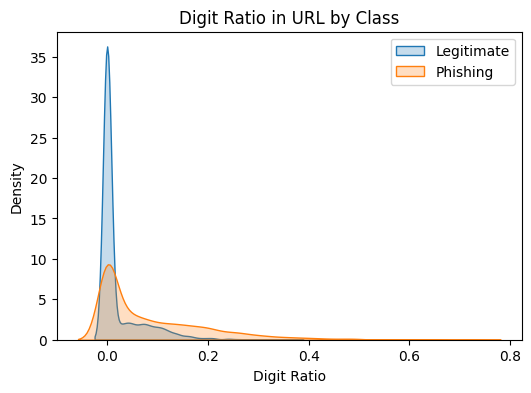

In [ ]:
# ========= EDA (PHISHING DETECTION) =========
import matplotlib.pyplot as plt
import seaborn as sns

# Class Distribution
plt.figure(figsize=(6,4))
sns.countplot(x='status', data=df)
plt.title("Class Distribution (Legitimate vs Phishing)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()



# URL Length Analysis
plt.figure(figsize=(6,4))
sns.boxplot(x='status', y='length_url', data=df)
plt.title("URL Length by Class")
plt.xlabel("Class")
plt.ylabel("URL Length")
plt.show()



# Number of Dots in URL
plt.figure(figsize=(6,4))
sns.boxplot(x='status', y='nb_dots', data=df)
plt.title("Number of Dots by Class")
plt.xlabel("Class")
plt.ylabel("Number of Dots")
plt.show()

# Digit Ratio in URL
plt.figure(figsize=(6,4))
sns.kdeplot(df[df['status']=='legitimate']['ratio_digits_url'], label='Legitimate', shade=True)
sns.kdeplot(df[df['status']=='phishing']['ratio_digits_url'], label='Phishing', shade=True)
plt.title("Digit Ratio in URL by Class")
plt.xlabel("Digit Ratio")
plt.ylabel("Density")
plt.legend()
plt.show()


In [ ]:
# ========== 3) FEATURE SELECTION ==========
from sklearn.feature_selection import SelectKBest, mutual_info_classif

k = min(30, X_train.shape[1])  # choose 30 or fewer if fewer features
selector = SelectKBest(score_func=mutual_info_classif, k=k)
X_train_k = selector.fit_transform(X_train, y_train)
X_test_k  = selector.transform(X_test)

selected_idx = np.where(selector.get_support())[0]
selected_feature_names = X.columns[selected_idx]
print("Selected features (k):", k)
print(list(selected_feature_names))

Selected features (k): 30
['length_url', 'length_hostname', 'ip', 'nb_dots', 'nb_www', 'ratio_digits_url', 'ratio_digits_host', 'char_repeat', 'shortest_word_host', 'longest_words_raw', 'longest_word_path', 'avg_words_raw', 'avg_word_host', 'avg_word_path', 'phish_hints', 'nb_hyperlinks', 'ratio_intHyperlinks', 'ratio_extHyperlinks', 'ratio_extRedirection', 'ratio_extErrors', 'links_in_tags', 'ratio_intMedia', 'ratio_extMedia', 'safe_anchor', 'domain_in_title', 'domain_registration_length', 'domain_age', 'web_traffic', 'google_index', 'page_rank']


In [ ]:
# ========== 4) BUILD MODELS ==========
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Classical models
dt = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
svm = SVC(kernel='rbf', probability=True, random_state=42)

# Simple Neural Network (Sequential)
nn = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_k.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
nn.compile(optimizer=Adam(learning_rate=0.001),
           loss='binary_crossentropy',
           metrics=['accuracy'])

models = {
    "DecisionTree": dt,
    "RandomForest": rf,
    "SVM": svm,
    "NeuralNet": nn
}

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# ========== 5) TRAIN & EVALUATE ==========
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import pandas as pd

results = []

# Train traditional models
for name in ["DecisionTree","RandomForest","SVM"]:
    clf = models[name]
    clf.fit(X_train_k, y_train)
    y_pred = clf.predict(X_test_k)
    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec  = recall_score(y_test, y_pred)
    f1   = f1_score(y_test, y_pred)
    results.append([name, acc, prec, rec, f1])

# Train Neural Network
history = models["NeuralNet"].fit(
    X_train_k, y_train, epochs=20, batch_size=32,
    validation_split=0.2, verbose=0
)
y_pred_nn = (models["NeuralNet"].predict(X_test_k) > 0.5).astype(int)
acc  = accuracy_score(y_test, y_pred_nn)
prec = precision_score(y_test, y_pred_nn)
rec  = recall_score(y_test, y_pred_nn)
f1   = f1_score(y_test, y_pred_nn)
results.append(["NeuralNet", acc, prec, rec, f1])

# Display comparison
res_df = pd.DataFrame(results, columns=["Model","Accuracy","Precision","Recall","F1"])
display(res_df.sort_values("F1", ascending=False).reset_index(drop=True))

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


,Model,Accuracy,Precision,Recall,F1
0,RandomForest,0.956693,0.953125,0.960630,0.956863
1,NeuralNet,0.950131,0.951712,0.948381,0.950044
2,SVM,0.943570,0.941638,0.945757,0.943693
3,DecisionTree,0.932633,0.931878,0.933508,0.932692


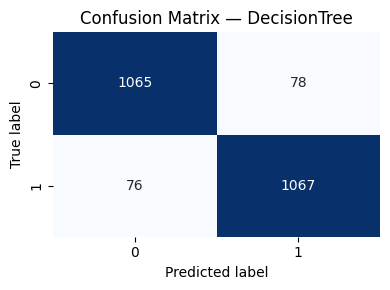

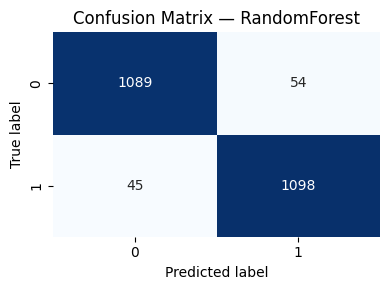

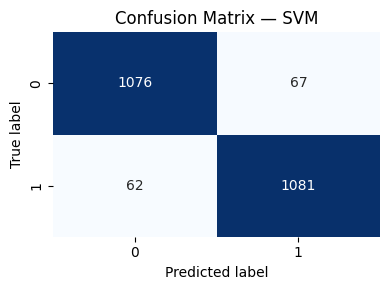

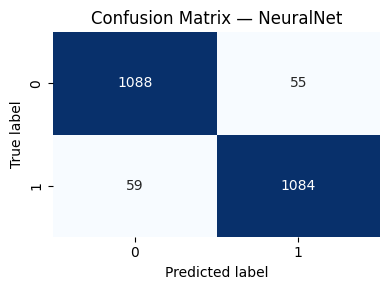

In [ ]:
# ========== 6) VISUALIZATIONS ==========
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, RocCurveDisplay

# --- a) Confusion Matrices ---
for name, model in models.items():
    if name == "NeuralNet":
        y_pred = y_pred_nn
    else:
        y_pred = model.predict(X_test_k)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"Confusion Matrix — {name}")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.tight_layout()
    plt.show()



72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


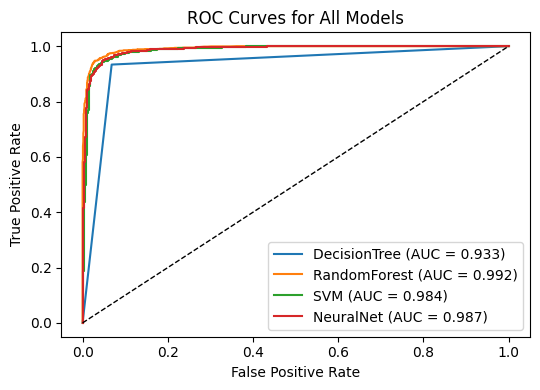

In [ ]:
# --- b) ROC Curves  ---
from sklearn.metrics import roc_curve, roc_auc_score

plt.figure(figsize=(5.5,4))
for name, model in models.items():
    if name == "NeuralNet":
        y_proba = models["NeuralNet"].predict(X_test_k).ravel()
    elif hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test_k)[:,1]
    else:
        continue

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")

plt.plot([0,1], [0,1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for All Models")
plt.legend()
plt.tight_layout()
plt.show()


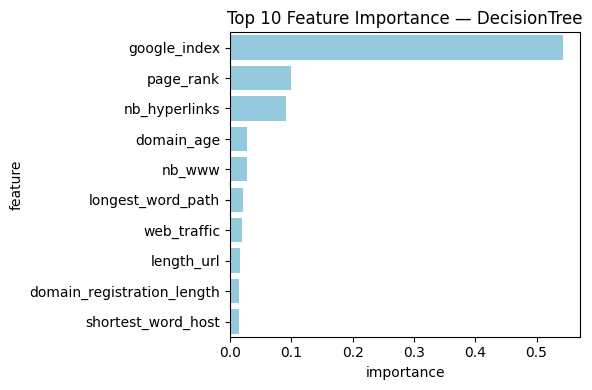

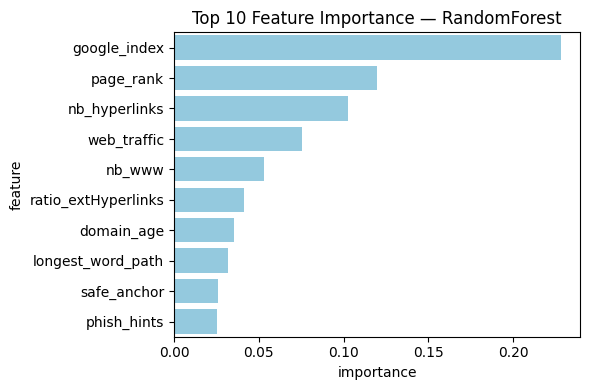

In [ ]:
# --- c) Feature Importance (Tree-Based Models) ---
tree_models = ["DecisionTree", "RandomForest"]
for name in tree_models:
    model = models[name]
    importance = model.feature_importances_
    imp_df = pd.DataFrame({
        "feature": selected_feature_names,
        "importance": importance
    }).sort_values("importance", ascending=False).head(10)

    plt.figure(figsize=(6,4))
    sns.barplot(x="importance", y="feature", data=imp_df, color="skyblue")
    plt.title(f"Top 10 Feature Importance — {name}")
    plt.tight_layout()
    plt.show()